In [31]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import seaborn as sns
from ruptures import Pelt
from ruptures.metrics import hausdorff
pd.set_option('display.max_colwidth', None)
import math


In [33]:
index_kurento_names = [
    "loadtest-webrtc-final-kurento-2p-t3medium",
    "loadtest-webrtc-final-kurento-2p-t3medium-2",
    "loadtest-webrtc-final-kurento-2p-t3medium-wait",
    "loadtest-webrtc-final-kurento-2p-t3medium-retry",
    "loadtest-webrtc-final-kurento-5p-t3medium",
    "loadtest-webrtc-final-kurento-5p-t3medium-2",
    "loadtest-webrtc-final-kurento-5p-t3medium-wait",
    "loadtest-webrtc-final-kurento-5p-t3medium-retry",
    "loadtest-webrtc-final-kurento-8p-t3medium",
    "loadtest-webrtc-final-kurento-8p-t3medium-2",
    "loadtest-webrtc-final-kurento-8p-t3medium-wait",
    "loadtest-webrtc-final-kurento-8p-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-2",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-kurento-3p-40s-t3medium-retry",
]

index_mediasoup_names = [
    "loadtest-webrtc-final-mediasoup-2p-t3medium",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-2p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-5p-t3medium",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-5p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-8p-t3medium",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-2",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-8p-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-20s-t3medium-retry",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-2",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-wait",
    "loadtest-webrtc-final-mediasoup-3p-40s-t3medium-retry",
]

index_livekit_names = [
    "loadtest-webrtc-final-livekit-2p-t3medium-retry",
    "loadtest-webrtc-final-livekit-8p-t3medium-retry",
    "loadtest-webrtc-final-livekit-3p-10s-t3medium-retry",
    "loadtest-webrtc-final-livekit-3p-40s-t3medium-retry",
]

index_list_names = index_kurento_names + index_mediasoup_names + index_livekit_names

node_types = ["browseremulator", "masternode", "medianode"]
packet_types = ["inbound", "outbound"]

seconds_per_fragment = 17

start_end_times = pd.read_json("dfs_final/start-end-times.json", orient="index")
start_end_times["from"] = pd.to_datetime(
    start_end_times["from"], format="ISO8601", utc=True
).dt.tz_convert("UTC")
start_end_times["to"] = pd.to_datetime(
    start_end_times["to"], format="ISO8601", utc=True
).dt.tz_convert("UTC")


def timestamp_to_secs(df_node, index, cpu_times=True):
    df_tmp = df_node.copy()
    df_tmp["@timestamp"] = pd.to_datetime(df_tmp["@timestamp"], format="ISO8601")
    tmp_serie = pd.Series(
        [df_tmp["@timestamp"].max(), start_end_times.loc[index, "to"]]
    )
    end_time = tmp_serie.min() if cpu_times else tmp_serie.max()
    df_tmp = df_tmp[df_tmp["@timestamp"] < end_time]
    tmp_serie = pd.Series(
        [df_tmp["@timestamp"].min(), start_end_times.loc[index, "from"]]
    )
    start_time = tmp_serie.max() if cpu_times else tmp_serie.min()
    df_tmp["timestamp_secs"] = (df_tmp["@timestamp"] - start_time).dt.total_seconds()
    df_tmp = df_tmp[df_tmp["timestamp_secs"] >= 0]
    return df_tmp

In [34]:
df_list = [
    pd.read_csv(f"dfs_final/{x}.csv")
    if os.path.isfile(f"dfs_final/{x}.csv")
    else pd.DataFrame()
    for x in index_list_names
]

df_user_join_list = [
    pd.read_csv(f"dfs_final/{x}-user-join.csv")
    if os.path.isfile(f"dfs_final/{x}-user-join.csv")
    else pd.DataFrame()
    for x in index_list_names
]

for i, df_user in enumerate(df_list):
    if not df_user.empty:
        index = index_list_names[i]
        user_join = df_user_join_list[i]
        start_test_time = start_end_times.loc[index, "from"]

        df_user["@timestamp"] = pd.to_datetime(df_user["@timestamp"], format="ISO8601")
        user_join["@timestamp"] = pd.to_datetime(user_join["@timestamp"], format="ISO8601")

        df_user["cut_index"] = df_user["cut_index"].astype(float)

        # cut index starts at 0 for each video
        # we asume that video starts on the timestamp that the user joins
        # each fragment lasts *seconds_per_fragment* seconds
        # for each row in user_join, change all entries with the same
        # user_join["participant"] and df_user["userFrom"]; and user_join["session"] and df_user["session"],
        # calculating its cut_index as
        # (user_join["@timestamp"] - start_test_time) + df_user["cut_index"] * seconds_per_fragment
        for _, row in user_join.iterrows():
            user_joined_at_sec = (row["@timestamp"] - start_test_time).total_seconds()
            data = df_user.loc[
                (df_user["userFrom"] == row["participant"])
                & (df_user["session"] == row["session"]),
                "cut_index"
            ] = df_user.loc[
                (df_user["userFrom"] == row["participant"])
                & (df_user["session"] == row["session"]),
                "cut_index"
            ] * seconds_per_fragment + user_joined_at_sec

index_data = []

data_types = node_types + packet_types


for i, index in enumerate(index_list_names):
    splitted = index.split("-")
    media_server = splitted[3]
    publishers = int(splitted[4][:-1])
    subscribers = int(splitted[5][:-1]) if splitted[5][-1] == "s" else 0
    users = publishers + subscribers
    repeat = "1" if splitted[-1] == "t3medium" else splitted[-1]

    index_data.append({
        "index": index,
        "media_server": media_server,
        "type": repeat,
        "publishers": publishers,
        "subscribers": subscribers,
        "users": users,
    })

index_data = pd.DataFrame(index_data)

In [35]:
data = []
metric = "pesq"
for i, df_tmp in enumerate(df_list):
    if not df_tmp.empty:
        average = df_tmp[metric].mean()
        median = df_tmp[metric].median()
        min = df_tmp[metric].min()
        max = df_tmp[metric].max()
        std = df_tmp[metric].std()
        data.append([index_list_names[i], average, median, std, min, max])

pd.DataFrame(data, columns=["index_type", "average", "median", "std", "min", "max"])

,index_type,average,median,std,min,max
0,loadtest-webrtc-final-kurento-2p-t3medium,0.705312,0.711812,0.021600,0.669500,0.738000
1,loadtest-webrtc-final-kurento-2p-t3medium-2,0.522406,0.592688,0.177451,0.110000,0.753625
2,loadtest-webrtc-final-kurento-2p-t3medium-wait,0.514297,0.537125,0.182658,-0.250000,0.773875
3,loadtest-webrtc-final-kurento-2p-t3medium-retry,0.501990,0.511000,0.160402,0.003250,0.771000
4,loadtest-webrtc-final-kurento-5p-t3medium,0.482277,0.525125,0.206590,-0.250000,0.776000
5,loadtest-webrtc-final-kurento-5p-t3medium-2,0.464812,0.464187,0.144589,0.048625,0.755125
6,loadtest-webrtc-final-kurento-5p-t3medium-wait,0.484261,0.525625,0.211120,-0.250000,0.768250
7,loadtest-webrtc-final-kurento-5p-t3medium-retry,0.508624,0.516500,0.148509,-0.011125,0.774500
8,loadtest-webrtc-final-kurento-8p-t3medium,0.512855,0.542938,0.162855,0.126250,0.755625
9,loadtest-webrtc-final-kurento-8p-t3medium-2,0.476572,0.475687,0.163795,0.010125,0.763750


In [36]:
# INDIVIDUAL PLOTS PARAMETERS

# Index of index_list to use
index = 45
# If there is only one metric in display, choose which one
metric = "vmaf"

show_full_range = True

# Calculations
index_name = index_list_names[index]
metric_label = metric.upper()
qoe_metrics_normalized = ["vmaf", "msssim", "ssim", "vifp", "pesq", "visqol"]
qoe_metrics_not_normalized = ["psnr", "psnrhvs", "psnrhvsm"]
metrics = qoe_metrics_normalized + qoe_metrics_not_normalized

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]
colors = ["blue", "orange", "green", "red"]
k = 0

for metric in qoe_metrics_normalized:
    for i, df_tmp in enumerate(df_list):
        if not df_tmp.empty:
            if k == 0:
                fig, ax = plt.subplots()
            df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)
            plot_name = index_list_names[i]
            if not df_mean.empty:
                ax.plot(df_mean.index, df_mean[metric], label=plot_name)
                ax.axvline(
                    x=df_mean.index.max(),
                    linestyle="--",
                    alpha=0.7,
                )
                ax.axvline(
                    x=df_mean.index.min(),
                    linestyle="--",
                    alpha=0.7,
                )

            if k == 3:
                ax.set_xlabel("timestamp (seconds)")
                ax.set_ylabel(metric)
                ax.grid()
                ax.set_ylim(-0.5, 1.05)
                ax.set_yticks(np.arange(-0.5, 1.05, 0.05))
                fig.legend(loc="lower left")
                fig.suptitle(f"{metric} over time (mean, {plot_name})")
                fig.savefig(f"images_final/{plot_name}_{metric}.png")
            k = (k + 1) % 4

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "orange", "green", "red"]
for typology in typologies:
    for media_node in media_nodes:
        fig, ax = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x, index_list_names
        )

        max_x = -1
        for i, target_name in enumerate(target_names):
            df_node = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            df_node = timestamp_to_secs(df_node, target_name)
            df_node = df_node.drop(columns=["@timestamp", "memory"]).dropna()
            ax.plot(
                df_node["timestamp_secs"],
                df_node["cpu"],
                color=colors[i],
                label=target_name,
            )
            plt.axvline(
                x=df_node["timestamp_secs"].max(),
                color=colors[i],
                linestyle="--",
                alpha=0.7,
                label="End of test " + target_name,
            )
            max_x = np.max(np.array([max_x, df_node["timestamp_secs"].max()]))

        ax.set_xlabel("timestamp (seconds)")
        ax.set_ylabel("CPU usage (%)")
        ax.grid()
        ax.set_ylim(0, 1.05)
        ax.set_yticks(np.arange(0, 1.05, 0.05))
        # ax.set_xticks(np.arange(0, max_x, 120))

        fig.suptitle(f"CPU usage over time ({typology}, {media_node})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_cpu.png")

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]
fig, ax = plt.subplots()

webrtc_stats_y = ax.twinx()

aggregation_map = {"@timestamp": "first"}
for metric in qoe_metrics_normalized:
    aggregation_map[metric] = "mean"

df_tmp = df_list[index].groupby("cut_index").agg(aggregation_map)
df_tmp = timestamp_to_secs(df_tmp, index_name)
df_node = pd.read_csv(f"dfs_final/{index_name}-medianode.csv")
df_node = timestamp_to_secs(df_node, index_name)
df = df_tmp

df_node_cpu = df_node.drop(columns=["memory"]).dropna()
df_node_memory = df_node.drop(columns=["cpu"]).dropna()

df_stats_inbound = pd.read_csv(f"dfs_final/{index_name}-webrtc-stats-inbound.csv")
df_stats_outbound = pd.read_csv(f"dfs_final/{index_name}-webrtc-stats-outbound.csv")
df_stats_inbound["@timestamp"] = pd.to_datetime(
    df_stats_inbound["@timestamp"], format="ISO8601"
)
df_stats_outbound["@timestamp"] = pd.to_datetime(
    df_stats_outbound["@timestamp"], format="ISO8601"
)
df_stats_inbound = df_stats_inbound.drop(columns="user_id")
df_stats_outbound = df_stats_outbound.drop(columns="user_id")
df_stats_inbound = df_stats_inbound.groupby("@timestamp").mean()
df_stats_outbound = df_stats_outbound.groupby("@timestamp").mean()

df_stats_inbound = timestamp_to_secs(df_stats_inbound, index_name)
df_stats_outbound = timestamp_to_secs(df_stats_outbound, index_name)

qoe_zorder = 10
resource_zorder = 0

qoe_linewidth = 3
resource_linewidth = 1

legend_handles = []
for metric in qoe_metrics_normalized:
    legend_handles.append(
        ax.plot(
            df["@timestamp"],
            df[metric],
            label=metric,
            marker="o",
            zorder=qoe_zorder,
            lw=qoe_linewidth,
        )
    )
legend_handles.append(
    ax.plot(
        df_node_cpu["@timestamp"],
        df_node_cpu["cpu"],
        "g",
        label="cpu",
        zorder=resource_zorder,
        lw=resource_linewidth,
        linestyle="--",
    )
)
legend_handles.append(
    ax.plot(
        df_node_memory["@timestamp"],
        df_node_memory["memory"],
        "c",
        label="memory",
        zorder=resource_zorder,
        lw=resource_linewidth,
        linestyle="--",
    )
)


for column in df_stats_inbound.columns[1:]:
    # Maybe readd gpSum?
    if (
        not "bytesSent" in column
        and not "packetsSent" in column
        and not "qpSum" in column
        and not "framesEncoded" in column
    ):
        legend_handles.append(
            webrtc_stats_y.plot(
                df_stats_inbound.index, df_stats_inbound[column], label=column
            )
        )

ax.set_title(f"QOE metric (normalized) over time (mean, worker data, {index_name})")
ax.set_xlabel("timestamp (day hour:minute)")
ax.set_ylabel("QOE metric (normalized), CPU %, Memory %")
webrtc_stats_y.set_ylabel("WebRTC stats")
ax.grid()
ax.legend(loc="upper left")
webrtc_stats_y.legend(loc="center left")

In [ ]:
def ols(dir, x_label, df):
    os.makedirs(dir, exist_ok=True)
    X = df[x_label]


    X = sm.add_constant(X)  # adding a constant
    for metric in metrics:
        Y = df[metric]

        model = sm.OLS(Y, X).fit()
        summary = model.summary()

        with open(f"{dir}/{metric}-summary.tex", "w") as fh:
            fh.write(summary.as_latex())

        with open(f"{dir}/{metric}-summary.html", "w") as fh:
            fh.write(summary.as_html())

        with open(f"{dir}/{metric}.txt", "w") as fh:
            fh.write(summary.as_text())

In [ ]:
df_tmp = pd.concat(df_list, ignore_index=True)
ols("results_ols/results_all", "user_count", df_tmp)

df_tmp = pd.concat(df_list[:24], ignore_index=True)
ols("results_ols/results_kurento", "user_count", df_tmp)

df_tmp = pd.concat(df_list[24:48], ignore_index=True)
ols("results_ols/results_mediasoup", "user_count", df_tmp)

df_tmp = pd.concat(df_list[48:], ignore_index=True)
ols("results_ols/results_livekit", "user_count", df_tmp)

In [ ]:
df_merged_list = []

df_webrtc_inbound_merged_list = []
df_webrtc_outbound_merged_list = []

for i, df_tmp in enumerate(df_list):

    index_name = index_list_names[i]

    df_node = pd.read_csv(f"dfs_final/{index_name}-medianode.csv")

    df_node = df_node.drop(columns=["memory"]).dropna()

    df_tmp = timestamp_to_secs(df_tmp, index_name, False)

    df_node = timestamp_to_secs(df_node, index_name, False)

    df_tmp["timestamp_secs"] = df_tmp["timestamp_secs"].round(-1)

    df_node["timestamp_secs"] = df_node["timestamp_secs"].round(-1)

    # df_tmp = df_tmp.groupby(["timestamp_secs"]).mean(numeric_only=True)


    merged_df = pd.merge(df_tmp, df_node, on="timestamp_secs", how="inner")


    df_merged_list.append(merged_df)

    df_webrtc_inbound = pd.read_csv(f"dfs_final/{index_name}-webrtc-stats-inbound.csv")

    df_webrtc_inbound = timestamp_to_secs(df_webrtc_inbound, index_name, False)
    df_webrtc_inbound["timestamp_secs"] = df_webrtc_inbound["timestamp_secs"].round(-1)

    merged_inbound_df = pd.merge(
        df_tmp, df_webrtc_inbound, on="timestamp_secs", how="inner"
    )

    df_webrtc_inbound_merged_list.append(merged_inbound_df)

    df_webrtc_outbound = pd.read_csv(
        f"dfs_final/{index_name}-webrtc-stats-outbound.csv"
    )

    df_webrtc_outbound = timestamp_to_secs(df_webrtc_outbound, index_name, False)
    df_webrtc_outbound["timestamp_secs"] = df_webrtc_outbound["timestamp_secs"].round(
        -1
    )

    merged_outbound_df = pd.merge(
        df_tmp, df_webrtc_outbound, on="timestamp_secs", how="inner"
    )

    df_webrtc_outbound_merged_list.append(merged_outbound_df)

In [ ]:
df_tmp = pd.concat(df_merged_list, ignore_index=True)
ols("results_ols/results_all_cpu", "cpu", df_tmp)

df_tmp = pd.concat(df_merged_list[:24], ignore_index=True)
ols("results_ols/results_kurento_cpu", "cpu", df_tmp)

df_tmp = pd.concat(df_merged_list[24:], ignore_index=True)
ols("results_ols/results_mediasoup_cpu", "cpu", df_tmp)

In [ ]:
df_tmp = pd.concat(
    [
        df_list[0],
        df_list[1],
        df_list[4],
        df_list[5],
        df_list[8],
        df_list[9],
        df_list[12],
        df_list[13],
        df_list[16],
        df_list[17],
        df_list[20],
        df_list[21],
        df_list[24],
        df_list[25],
        df_list[28],
        df_list[29],
        df_list[32],
        df_list[33],
        df_list[36],
        df_list[37],
        df_list[40],
        df_list[41],
        df_list[44],
        df_list[45],
    ],
    ignore_index=True,
)
ols("results_ols/results_default_all", "user_count", df_tmp)

df_tmp = pd.concat(
    [
        df_list[2],
        df_list[6],
        df_list[10],
        df_list[14],
        df_list[18],
        df_list[22],
        df_list[26],
        df_list[30],
        df_list[34],
        df_list[38],
        df_list[42],
        df_list[46],
    ],
    ignore_index=True,
)
ols("results_ols/results_wait_all", "user_count", df_tmp)

df_tmp = pd.concat(
    [
        df_list[3],
        df_list[7],
        df_list[11],
        df_list[15],
        df_list[19],
        df_list[23],
        df_list[27],
        df_list[31],
        df_list[35],
        df_list[39],
        df_list[43],
        df_list[47],
    ],
    ignore_index=True,
)
ols("results_ols/results_retry_all", "user_count", df_tmp)

df_tmp = pd.concat(
    [    
        df_list[0],
        df_list[1],
        df_list[4],
        df_list[5],
        df_list[8],
        df_list[9],
        df_list[12],
        df_list[13],
        df_list[16],
        df_list[17],
        df_list[20],
        df_list[21],
        df_list[24]
    ],
    ignore_index=True,
)
ols("results_ols/results_default_kurento", "user_count", df_tmp)

df_tmp = pd.concat(
    [
        df_list[2],
        df_list[6],
        df_list[10],
        df_list[14],
        df_list[18],
        df_list[22],
    ],
    ignore_index=True,
)
ols("results_ols/results_wait_kurento", "user_count", df_tmp)

df_tmp = pd.concat(
    [
        df_list[3],
        df_list[7],
        df_list[11],
        df_list[15],
        df_list[19],
        df_list[23],
    ],
    ignore_index=True,
)
ols("results_ols/results_retry_kurento", "user_count", df_tmp)

df_tmp = pd.concat(
    [
        df_list[24],
        df_list[25],
        df_list[28],
        df_list[29],
        df_list[32],
        df_list[33],
        df_list[36],
        df_list[37],
        df_list[40],
        df_list[41],
        df_list[44],
        df_list[45],
    ],
    ignore_index=True,
)
ols("results_ols/results_default_mediasoup", "user_count", df_tmp)

df_tmp = pd.concat(
    [
        df_list[26],
        df_list[30],
        df_list[34],
        df_list[38],
        df_list[42],
        df_list[46],
    ],
    ignore_index=True,
)
ols("results_ols/results_wait_mediasoup", "user_count", df_tmp)

df_tmp = pd.concat(
    [
        df_list[27],
        df_list[31],
        df_list[35],
        df_list[39],
        df_list[43],
        df_list[47],
    ],
    ignore_index=True,
)
ols("results_ols/results_retry_mediasoup", "user_count", df_tmp)


In [ ]:
df_tmp = pd.concat(
    [
        df_merged_list[0],
        df_merged_list[1],
        df_merged_list[4],
        df_merged_list[5],
        df_merged_list[8],
        df_merged_list[9],
        df_merged_list[12],
        df_merged_list[13],
        df_merged_list[16],
        df_merged_list[17],
        df_merged_list[20],
        df_merged_list[21],
        df_merged_list[24],
        df_merged_list[25],
        df_merged_list[28],
        df_merged_list[29],
        df_merged_list[32],
        df_merged_list[33],
        df_merged_list[36],
        df_merged_list[37],
        df_merged_list[40],
        df_merged_list[41],
        df_merged_list[44],
        df_merged_list[45],
    ],
    ignore_index=True,
)
ols("results_ols/results_default_all_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [
        df_merged_list[2],
        df_merged_list[6],
        df_merged_list[10],
        df_merged_list[14],
        df_merged_list[18],
        df_merged_list[22],
        df_merged_list[26],
        df_merged_list[30],
        df_merged_list[34],
        df_merged_list[38],
        df_merged_list[42],
        df_merged_list[46],
    ],
    ignore_index=True,
)
ols("results_ols/results_wait_all_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [
        df_merged_list[3],
        df_merged_list[7],
        df_merged_list[11],
        df_merged_list[15],
        df_merged_list[19],
        df_merged_list[23],
        df_merged_list[27],
        df_merged_list[31],
        df_merged_list[35],
        df_merged_list[39],
        df_merged_list[43],
        df_merged_list[47],
    ],
    ignore_index=True,
)
ols("results_ols/results_retry_all_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [    
        df_merged_list[0],
        df_merged_list[1],
        df_merged_list[4],
        df_merged_list[5],
        df_merged_list[8],
        df_merged_list[9],
        df_merged_list[12],
        df_merged_list[13],
        df_merged_list[16],
        df_merged_list[17],
        df_merged_list[20],
        df_merged_list[21],
        df_merged_list[24]
    ],
    ignore_index=True,
)
ols("results_ols/results_default_kurento_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [
        df_merged_list[2],
        df_merged_list[6],
        df_merged_list[10],
        df_merged_list[14],
        df_merged_list[18],
        df_merged_list[22],
    ],
    ignore_index=True,
)
ols("results_ols/results_wait_kurento_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [
        df_merged_list[3],
        df_merged_list[7],
        df_merged_list[11],
        df_merged_list[15],
        df_merged_list[19],
        df_merged_list[23],
    ],
    ignore_index=True,
)
ols("results_ols/results_retry_kurento_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [
        df_merged_list[24],
        df_merged_list[25],
        df_merged_list[28],
        df_merged_list[29],
        df_merged_list[32],
        df_merged_list[33],
        df_merged_list[36],
        df_merged_list[37],
        df_merged_list[40],
        df_merged_list[41],
        df_merged_list[44],
        df_merged_list[45],
    ],
    ignore_index=True,
)
ols("results_ols/results_default_mediasoup_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [
        df_merged_list[26],
        df_merged_list[30],
        df_merged_list[34],
        df_merged_list[38],
        df_merged_list[42],
        df_merged_list[46],
    ],
    ignore_index=True,
)
ols("results_ols/results_wait_mediasoup_cpu", "cpu", df_tmp)

df_tmp = pd.concat(
    [
        df_merged_list[27],
        df_merged_list[31],
        df_merged_list[35],
        df_merged_list[39],
        df_merged_list[43],
        df_merged_list[47],
    ],
    ignore_index=True,
)
ols("results_ols/results_retry_mediasoup_cpu", "cpu", df_tmp)


In [ ]:
for i, df_tmp in enumerate(df_list):
    index_name = index_list_names[i]
    try:
        ols(f"results_ols/indexes/{index_name}", "user_count", df_tmp)
    except:
        print(f"Failed for {index_name}")

for i, df_tmp in enumerate(df_merged_list):
    index_name = index_list_names[i]
    try:
        ols(f"results_ols/indexes_cpu/{index_name}", "cpu", df_tmp)
    except:
        print(f"Failed (cpu) for {index_name}")

In [ ]:
from io import StringIO
from IPython.display import display, HTML

dir = "test/"

os.makedirs(dir, exist_ok=True)

#df = pd.concat(df_merged_list, ignore_index=True)

i = 24
df = df_merged_list[i]

df = df[df["cpu"] < 0.95]

X = df["user_count"]

metric = "cpu"

X = sm.add_constant(X)  # adding a constant
Y = df[metric]

model = sm.OLS(Y, X).fit()
summary = model.summary()

# with open(f"{dir}/{metric}-summary.tex", "w") as fh:
#     fh.write(summary.as_latex())

# with open(f"{dir}/{metric}-summary.html", "w") as fh:
#     fh.write(summary.as_html())

# with open(f"{dir}/{metric}.txt", "w") as fh:
#     fh.write(summary.as_text())
print(index_list_names[i])
display(pd.read_html(StringIO(summary.tables[1].as_html()), header=0, index_col=0)[0])

In [ ]:
plt.ioff()
for i in range(0,48):
    index_name = index_list_names[i]
    print(index_name)
    df = df_list[i]
    os.makedirs(f"images_final/sns/{index_name}", exist_ok=True)
    #df_merged = df_merged_list[i]


    # plot x cpu y vmaf 
    # fig, ax = plt.subplots()
    # sns.lineplot(data=df_merged, x="cpu", y="vmaf", ax=ax)
    df = df.sort_values(by=["user_count"])
    for metric in metrics:
        fig, ax = plt.subplots()
        if metric in qoe_metrics_normalized:
            ax.set_ylim(0, 1.05)
        ax.set_xlim(2, df["user_count"].max() + 1)
        ax.set_yticks(np.arange(0, 1.05, 0.1))
        sns.lineplot(data=df, x="user_count", y=metric, ax=ax)
        plt.grid()
        plt.savefig(f"images_final/sns/{index_name}/{metric}.png")

plt.ion()
# algo = Pelt(model="rbf").fit(df["vmaf"].values)
# result = algo.predict(pen=10)
# for breakpoint_idx in result:
#     breakpoint_value = df["user_count"].iloc[breakpoint_idx]
#     ax.scatter(breakpoint_value, df["vmaf"].iloc[breakpoint_idx], color='red', marker='o', s=100)

# #vertical line

# ax.axvline(x=result[0], linestyle="--", alpha=0.7, label="Change point")

In [ ]:
for i in range(0,48):
    print(index_list_names[i])
    # TODO: paint the webrtc stats results

In [ ]:
session_data = pd.read_json("dfs_final/session-data.json", orient="index")
for i, index in enumerate(index_list_names):
    df = df_list[i]
    user_count_max = df["user_count"].max()
    session_index_data = session_data.loc[index]
    session_data.loc[index, "user_count_max"] = user_count_max
session_data["registered ratio"] = session_data["user_count_max"].div(session_data["participants"]).mul(100)

session_data

In [ ]:
minio_items = pd.read_csv("dfs_final/minio_items.csv")


# Initialize columns
minio_items["sessions"] = 0
minio_items["videos per session"] = 0  # or any default value you want to set initially

minio_items = minio_items.value_counts(["index", "error"]).reset_index().sort_values(by=["index", "error"])

for index in minio_items["index"]:
    index_name = index_list_names.index(index)
    df = df_list[index_name]

    max_user_count = df["user_count"].max().astype(int)
    publishers = index_data.loc[index_data["index"] == index, "publishers"].values[0]
    subscribers = index_data.loc[index_data["index"] == index, "subscribers"].values[0]

    # Create a mask for the current index
    index_mask = minio_items["index"] == index

    # Update columns using vectorized operations
    minio_items.loc[index_mask, "user_count"] = max_user_count
    minio_items.loc[index_mask, "sessions"] = minio_items.loc[index_mask, "user_count"].div(publishers + subscribers).apply(math.ceil)
    minio_items.loc[index_mask, "videos per session"] = publishers * (publishers - 1) + subscribers * publishers
    minio_items.loc[index_mask, "total possible videos"] = minio_items.loc[index_mask, "sessions"] * minio_items.loc[index_mask, "videos per session"]

minio_items = minio_items[["index", "error", "total possible videos", "count", "sessions", "videos per session"]]


minio_items

In [ ]:
session_data = pd.read_json("dfs_final/session-data.json", orient="index")
df = pd.DataFrame(columns=["index", "first recorded user", "first recorded session", "calculated missing users data", "total registered users", "total added users", "missing user data ratio"])
for i, index in enumerate(index_list_names):
    df_tmp = df_list[i]
    df_short = df_tmp[["userFrom", "userTo", "session"]].copy()

    df_short["session"] = df_short["session"].str.extract(r"(\d+)", expand=False).astype(int)
    df_short["userFrom"] = df_short["userFrom"].str.extract(r"(\d+)", expand=False).astype(int)
    df_short["userTo"] = df_short["userTo"].str.extract(r"(\d+)", expand=False).astype(int)

    unique_sessions = df_short["session"].unique()
    possible_sessions = np.arange(1, unique_sessions.max() + 1)
    missing_sessions = len(np.setdiff1d(possible_sessions, unique_sessions))
    users_in_session = index_data.loc[index_data["index"] == index, "users"].values[0]
    missing_users = missing_sessions * users_in_session
    combinations = users_in_session * (users_in_session - 1)
    possible_users = np.arange(1, users_in_session + 1)
    for session in unique_sessions:
        if session != unique_sessions.max():
            df_session = df_short[df_short["session"] == session]
            usersTo = df_session["userTo"].unique()
            missing_users += len(np.setdiff1d(possible_users, usersTo))


    user_join = pd.read_csv(f"dfs_final/{index}-user-join.csv")
    user_join["@timestamp"] = pd.to_datetime(user_join["@timestamp"], format="ISO8601")

    df_tmp["nsession"] = df_tmp["session"].str.extract(r"(\d+)", expand=False).astype(int)
    df_tmp["nuserFrom"] = df_tmp["userFrom"].str.extract(r"(\d+)", expand=False).astype(int)

    min_timestamp_row = df_tmp.loc[df_tmp["nsession"].idxmin()]
    total_registered_users = df_tmp["user_count"].max()
    total_added_users = session_data.loc[index, "participants"]
    ratio = missing_users / total_added_users * 100
    #missing_users = calculate_missing_recordings()
    df.loc[len(df)] = [index, min_timestamp_row["nuserFrom"], min_timestamp_row["nsession"], missing_users, total_registered_users, total_added_users, ratio]


df = df.sort_values(by=["missing user data ratio"], ascending=False)

df = df[df["index"].str.contains("mediasoup") & ~df["index"].str.contains("0s")]

# Plotting histograms
plt.figure(figsize=(10, 6))
sns.histplot(df, x="missing user data ratio")
plt.xlabel("Missing User Data Ratio")
plt.ylabel("Frequency")
plt.title("Histogram of Missing User Data Ratio (Mediasoup, no subscribers)")
plt.legend()
plt.show()

print(f"Total: {len(df.index)}")

df

In [ ]:
minio_items = pd.read_csv("dfs_final/minio_items.csv")

minio_items = minio_items[minio_items["error"] == False]
minio_items = minio_items.value_counts(["index"]).reset_index().sort_values(by=["index"])


# Initialize columns
minio_items["sessions"] = 0
minio_items["videos per session"] = 0  # or any default value you want to set initially

for index in minio_items["index"]:
    index_name = index_list_names.index(index)
    df = df_list[index_name]
    user_joins = pd.read_csv(f"dfs_final/{index}-user-join.csv")
    user_joins["@timestamp"] = pd.to_datetime(user_joins["@timestamp"], format="ISO8601")

    max_user_count = df["user_count"].max().astype(int)
    min_user_count = df["user_count"].min().astype(int)
    publishers = int(index.split("-")[4][:-1])
    subscribers = int(index.split("-")[5][:-1]) if index.split("-")[5].endswith("s") else 0

    max_time: datetime = df["@timestamp"].max()
    min_time: datetime = np.min([df["@timestamp"].min(), user_joins["@timestamp"].min()])
    time = (max_time - min_time).total_seconds()

    start_time = start_end_times.loc[index, "from"]
    total_time = (start_end_times.loc[index, "to"] - start_time).total_seconds()

    # Create a mask for the current index
    index_mask = minio_items["index"] == index

    # Update columns using vectorized operations
    minio_items.loc[index_mask, "data starts at user"] = min_user_count
    minio_items.loc[index_mask, "data ends at user"] = max_user_count
    minio_items.loc[index_mask, "data loss (users)"] = max_user_count - min_user_count
    minio_items.loc[index_mask, "data loss (seconds)"] = (min_time - start_time).total_seconds()
    minio_items.loc[index_mask, "sessions"] = minio_items.loc[index_mask, "data ends at user"].div(publishers + subscribers).apply(math.ceil)
    minio_items.loc[index_mask, "videos per session"] = publishers * (publishers - 1) + subscribers * publishers
    minio_items.loc[index_mask, "total possible videos"] = minio_items.loc[index_mask, "sessions"] * minio_items.loc[index_mask, "videos per session"]
    minio_items.loc[index_mask, "video ratio"] = minio_items.loc[index_mask, "count"] / minio_items.loc[index_mask, "total possible videos"] * 100
    minio_items.loc[index_mask, "total time (secs)"] = total_time

minio_items = minio_items[["index", "total possible videos", "count", "video ratio", "data starts at user", "data ends at user", "data loss (users)", "total time (secs)", "data loss (seconds)"]]


#minio_items = minio_items[~minio_items["index"].str.contains("0s")]

minio_items = minio_items[minio_items["data starts at user"] <= minio_items["data ends at user"] * 0.25]

#minio_items = minio_items[minio_items["video ratio"] >= 50]

#minio_items = minio_items[minio_items["index"].str.contains("mediasoup")]

print(f"< 5 %: {len(minio_items[minio_items['video ratio'] < 5].index)}")
print(f"5 % < n < 25 %: {len(minio_items[(minio_items['video ratio'] >= 5) & (minio_items['video ratio'] < 25)].index)}")
print(f"25 % < n < 50 %: {len(minio_items[(minio_items['video ratio'] >= 25) & (minio_items['video ratio'] < 50)].index)}")
print(f"50 % < n < 75 %: {len(minio_items[(minio_items['video ratio'] >= 50) & (minio_items['video ratio'] < 75)].index)}")
print(f"75 % < n < 95 %: {len(minio_items[(minio_items['video ratio'] >= 75) & (minio_items['video ratio'] < 95)].index)}")
print(f"> 95 %: {len(minio_items[minio_items['video ratio'] >= 95].index)}")
print(f"Total: {len(minio_items.index)}")


minio_items.sort_values(by=["video ratio"], ascending=False)

df = pd.DataFrame(columns=["media server", "type", "publishers", "subscribers", "videos we have / possible total videos", "data starts at user", "data ends at user"])

for index in minio_items["index"]:
    index_data_row = index_data.loc[index_data["index"] == index]
    media_server = index_data_row["media_server"].values[0]
    type = index_data_row["type"].values[0]
    publishers = index_data_row["publishers"].values[0]
    subscribers = index_data_row["subscribers"].values[0]
    video_ratio = minio_items.loc[minio_items["index"] == index, "video ratio"].values[0]
    min_user_count = minio_items.loc[minio_items["index"] == index, "data starts at user"].values[0]
    max_user_count = minio_items.loc[minio_items["index"] == index, "data ends at user"].values[0]
    df.loc[len(df)] = [media_server, type, publishers, subscribers, video_ratio, min_user_count, max_user_count]

df

In [ ]:
minio_items[minio_items['video ratio'] < 5]

In [ ]:
minio_items[(minio_items['video ratio'] >= 5) & (minio_items['video ratio'] < 25)]

In [ ]:
minio_items[(minio_items['video ratio'] >= 25) & (minio_items['video ratio'] < 50)]

In [ ]:
minio_items[(minio_items['video ratio'] >= 25) & (minio_items['video ratio'] < 50)]

In [ ]:
minio_items[(minio_items['video ratio'] >= 50) & (minio_items['video ratio'] < 75)]

In [ ]:
minio_items[(minio_items['video ratio'] >= 75) & (minio_items['video ratio'] < 95)]

In [ ]:
minio_items[(minio_items['video ratio'] >= 95)]

In [ ]:
minio_items = pd.read_csv("dfs_final/minio_items.csv")

minio_items = minio_items[minio_items["error"] == True]
minio_items = minio_items.value_counts(["index"]).reset_index().sort_values(by=["index"])


# Initialize columns
minio_items["sessions"] = 0
minio_items["videos per session"] = 0  # or any default value you want to set initially

for index in minio_items["index"]:
    index_name = index_list_names.index(index)
    df = df_list[index_name]

    max_user_count = df["user_count"].max().astype(int)
    publishers = int(index.split("-")[4][:-1])
    subscribers = int(index.split("-")[5][:-1]) if index.split("-")[5].endswith("s") else 0

    # Create a mask for the current index
    index_mask = minio_items["index"] == index

    # Update columns using vectorized operations
    minio_items.loc[index_mask, "user_count"] = max_user_count
    minio_items.loc[index_mask, "sessions"] = minio_items.loc[index_mask, "user_count"].div(publishers + subscribers).apply(math.ceil)
    minio_items.loc[index_mask, "videos per session"] = publishers * (publishers - 1) + subscribers * publishers
    minio_items.loc[index_mask, "total possible videos"] = minio_items.loc[index_mask, "sessions"] * minio_items.loc[index_mask, "videos per session"]
    minio_items.loc[index_mask, "success ratio"] = minio_items.loc[index_mask, "count"] / minio_items.loc[index_mask, "total possible videos"] * 100

minio_items = minio_items[["index", "total possible videos", "count", "success ratio", "sessions", "videos per session"]]

minio_items

In [ ]:
minio_items = pd.read_csv("dfs_final/minio_items.csv")

minio_items = minio_items.value_counts(["index", "error"]).reset_index().sort_values(by=["index", "error"])

# remove error column and add the count of success and error in the same index
minio_items = minio_items.drop(columns=["error"]).groupby(["index"]).sum().reset_index()

# Initialize columns
minio_items["sessions"] = 0
minio_items["videos per session"] = 0  # or any default value you want to set initially

for index in minio_items["index"]:
    index_name = index_list_names.index(index)
    df = df_list[index_name]

    max_user_count = df["user_count"].max().astype(int)
    publishers = int(index.split("-")[4][:-1])
    subscribers = int(index.split("-")[5][:-1]) if index.split("-")[5].endswith("s") else 0

    # Create a mask for the current index
    index_mask = minio_items["index"] == index

    # Update columns using vectorized operations
    minio_items.loc[index_mask, "user_count"] = max_user_count
    minio_items.loc[index_mask, "sessions"] = minio_items.loc[index_mask, "user_count"].div(publishers + subscribers).apply(math.ceil)
    minio_items.loc[index_mask, "videos per session"] = publishers * (publishers - 1) + subscribers * publishers
    minio_items.loc[index_mask, "total possible videos"] = minio_items.loc[index_mask, "sessions"] * minio_items.loc[index_mask, "videos per session"]
    minio_items.loc[index_mask, "success ratio"] = minio_items.loc[index_mask, "count"] / minio_items.loc[index_mask, "total possible videos"] * 100

minio_items = minio_items[["index", "total possible videos", "count", "success ratio", "sessions", "videos per session"]]
print(f"< 5 %: {len(minio_items[minio_items['success ratio'] < 5].index)}")
print(f"5 % < n < 25 %: {len(minio_items[(minio_items['success ratio'] >= 5) & (minio_items['success ratio'] < 25)].index)}")
print(f"25 % < n < 50 %: {len(minio_items[(minio_items['success ratio'] >= 25) & (minio_items['success ratio'] < 50)].index)}")
print(f"50 % < n < 75 %: {len(minio_items[(minio_items['success ratio'] >= 50) & (minio_items['success ratio'] < 75)].index)}")
print(f"75 % < n < 95 %: {len(minio_items[(minio_items['success ratio'] >= 75) & (minio_items['success ratio'] < 95)].index)}")
print(f"> 95 %: {len(minio_items[minio_items['success ratio'] >= 95].index)}")
print(f"Total: {len(minio_items.index)}")

minio_items

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
colors = ["blue", "red"]
for typology in typologies:
    fig, ax = plt.subplots()
    target_names = filter(
        lambda x: (typology in x) and any(media_node in x for media_node in media_nodes) and "retry" in x, index_list_names
    )
    #max_x = -1
    for i, target_name in enumerate(target_names):
        df_node = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
        # remove entries with cpu < 0.001
        # df_node = df_node[df_node["cpu"] > 0.001]
        df_node = timestamp_to_secs(df_node, target_name)
        df_node = df_node.drop(columns=["@timestamp", "memory"]).dropna()
        ax.plot(
            df_node["timestamp_secs"],
            df_node["cpu"],
            color=colors[i],
            label=target_name,
        )
        plt.axvline(
            x=df_node["timestamp_secs"].max(),
            color=colors[i],
            linestyle="--",
            alpha=0.7,
            label="End of test " + target_name,
        )
        #max_x = np.max(np.array([max_x, df_node["timestamp_secs"].max()]))

    ax.set_xlabel("timestamp (seconds)")
    ax.set_ylabel("CPU usage (%)")
    ax.grid()
    ax.set_ylim(0, 1.05)
    ax.set_yticks(np.arange(0, 1.05, 0.05))
    #ax.set_xticks(np.arange(0, max_x, 120))

    fig.suptitle(f"CPU usage over time ({typology})")
    fig.legend(loc="right")
    fig.savefig(f"images_final/{typology}_cpu.png")

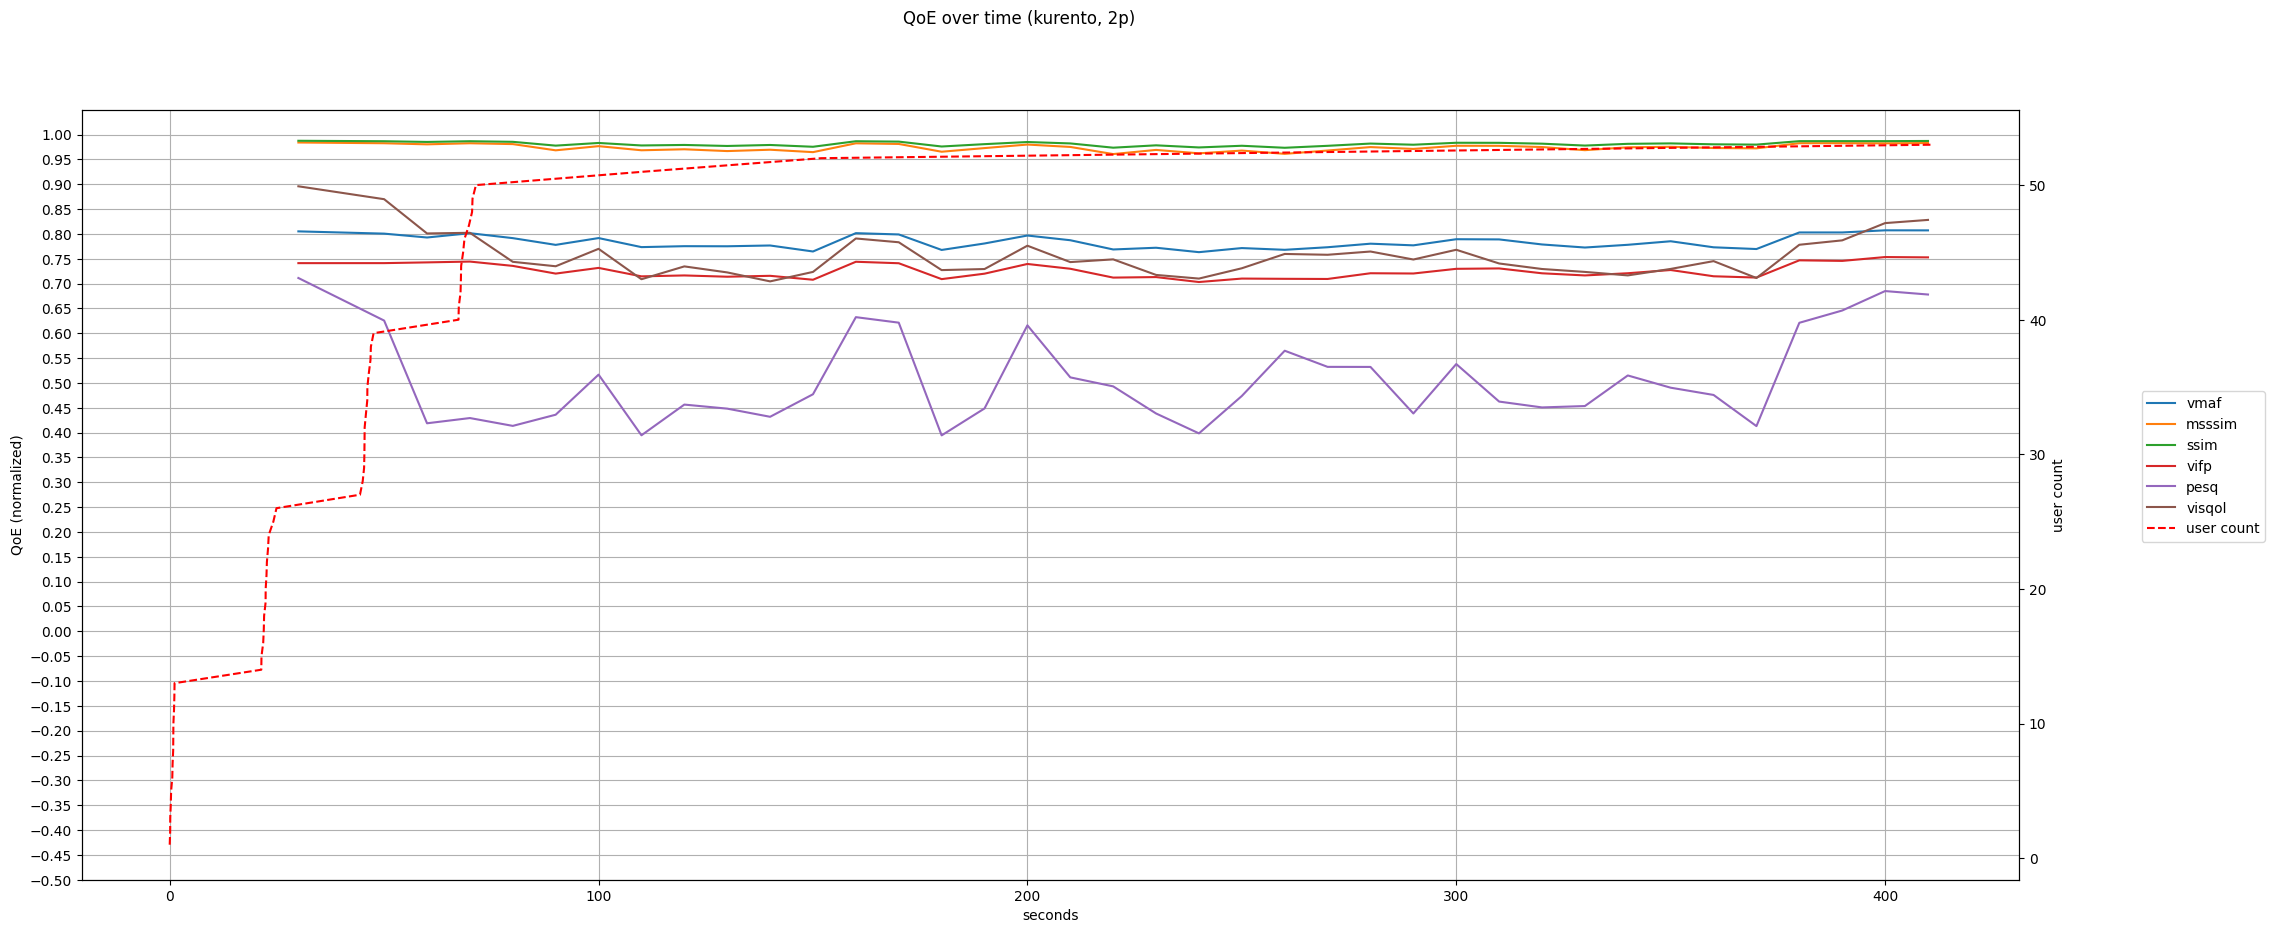

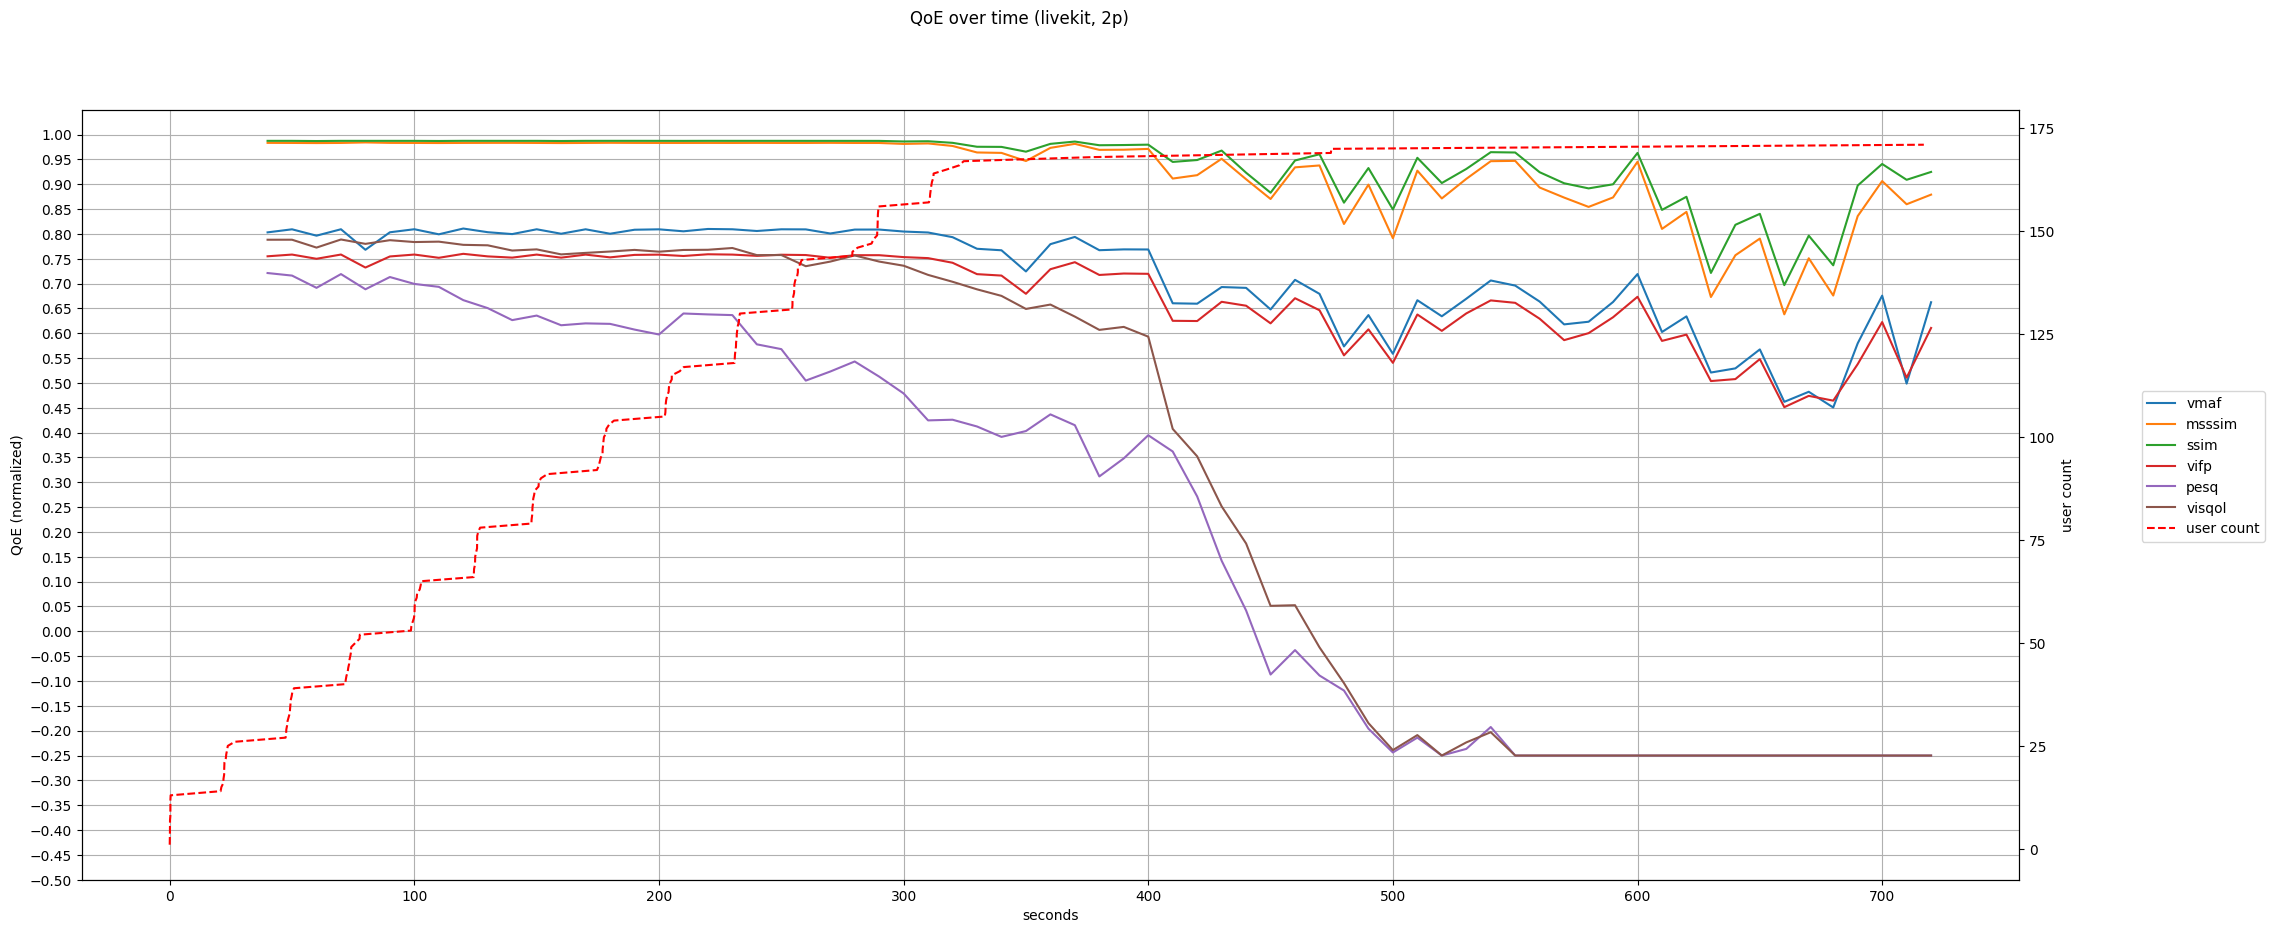

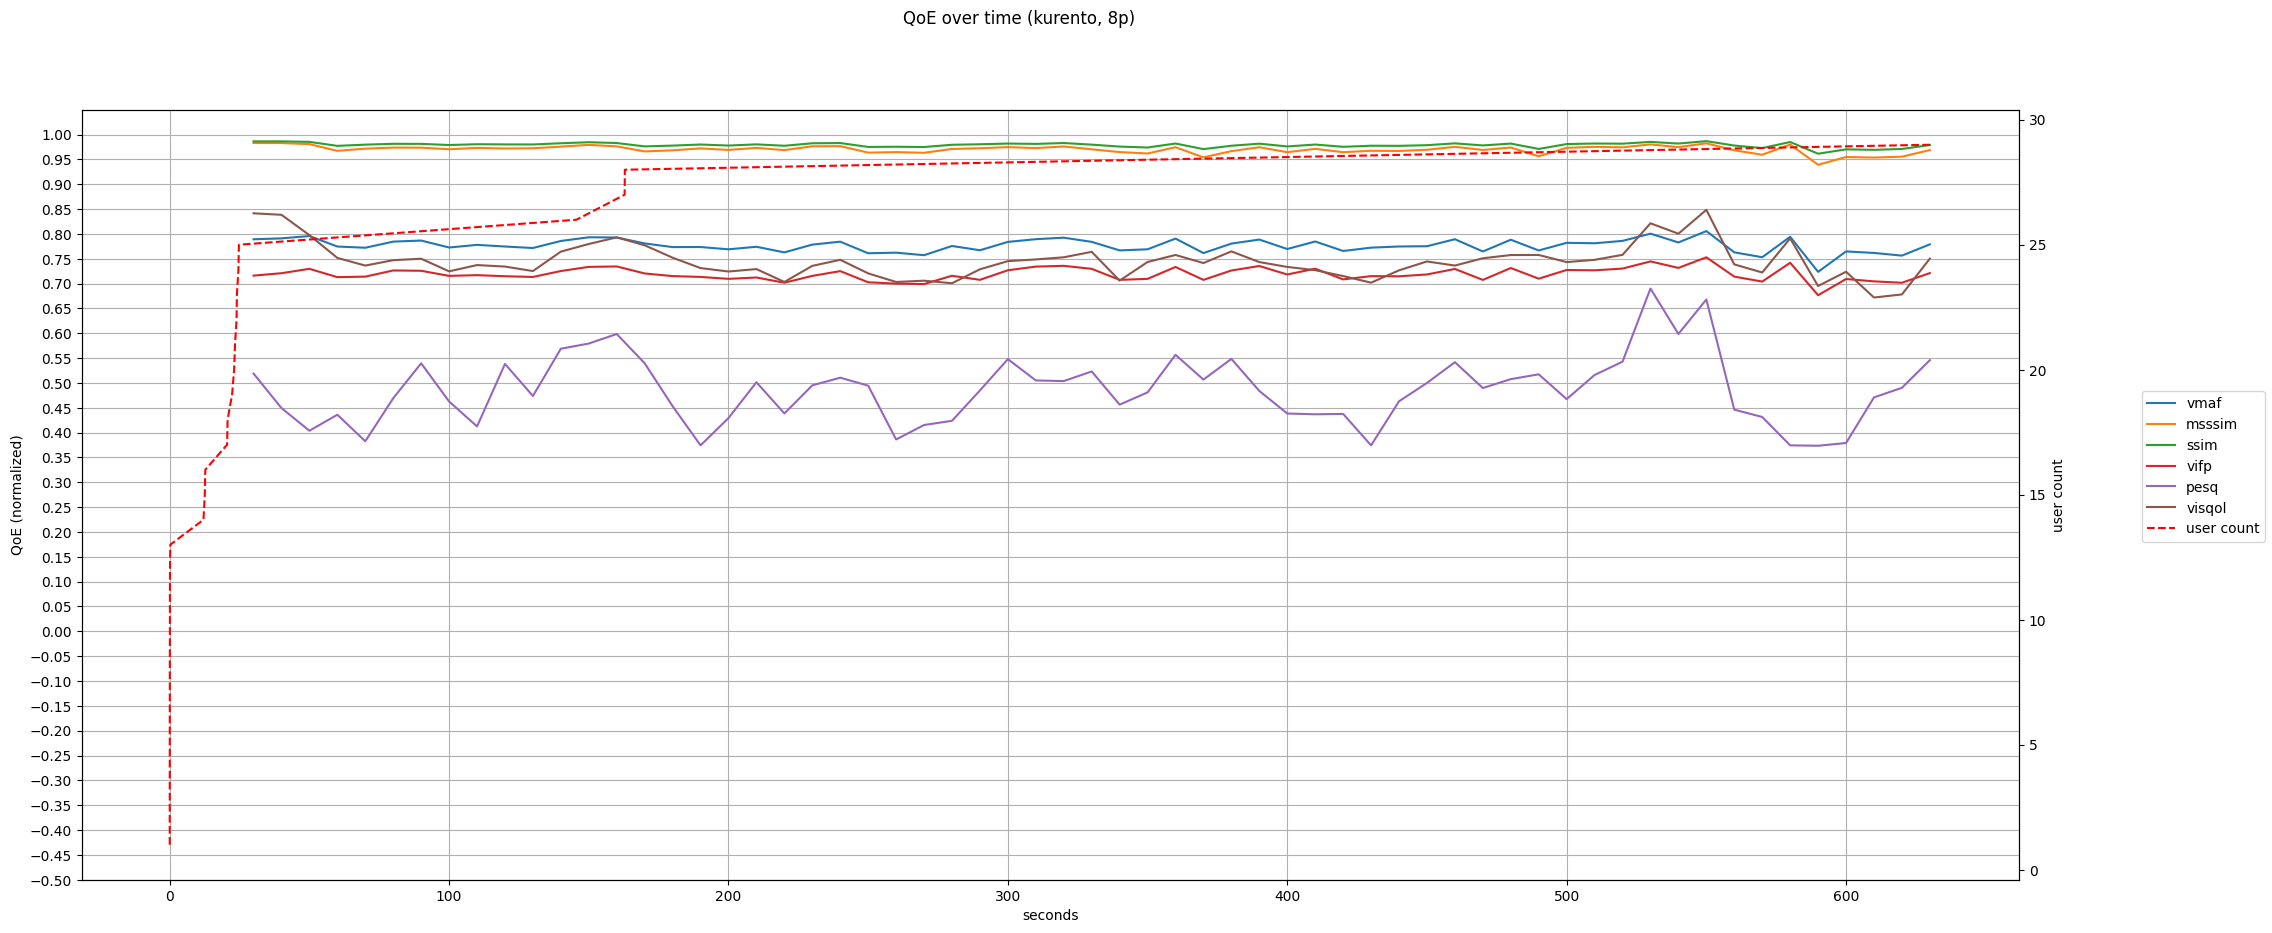

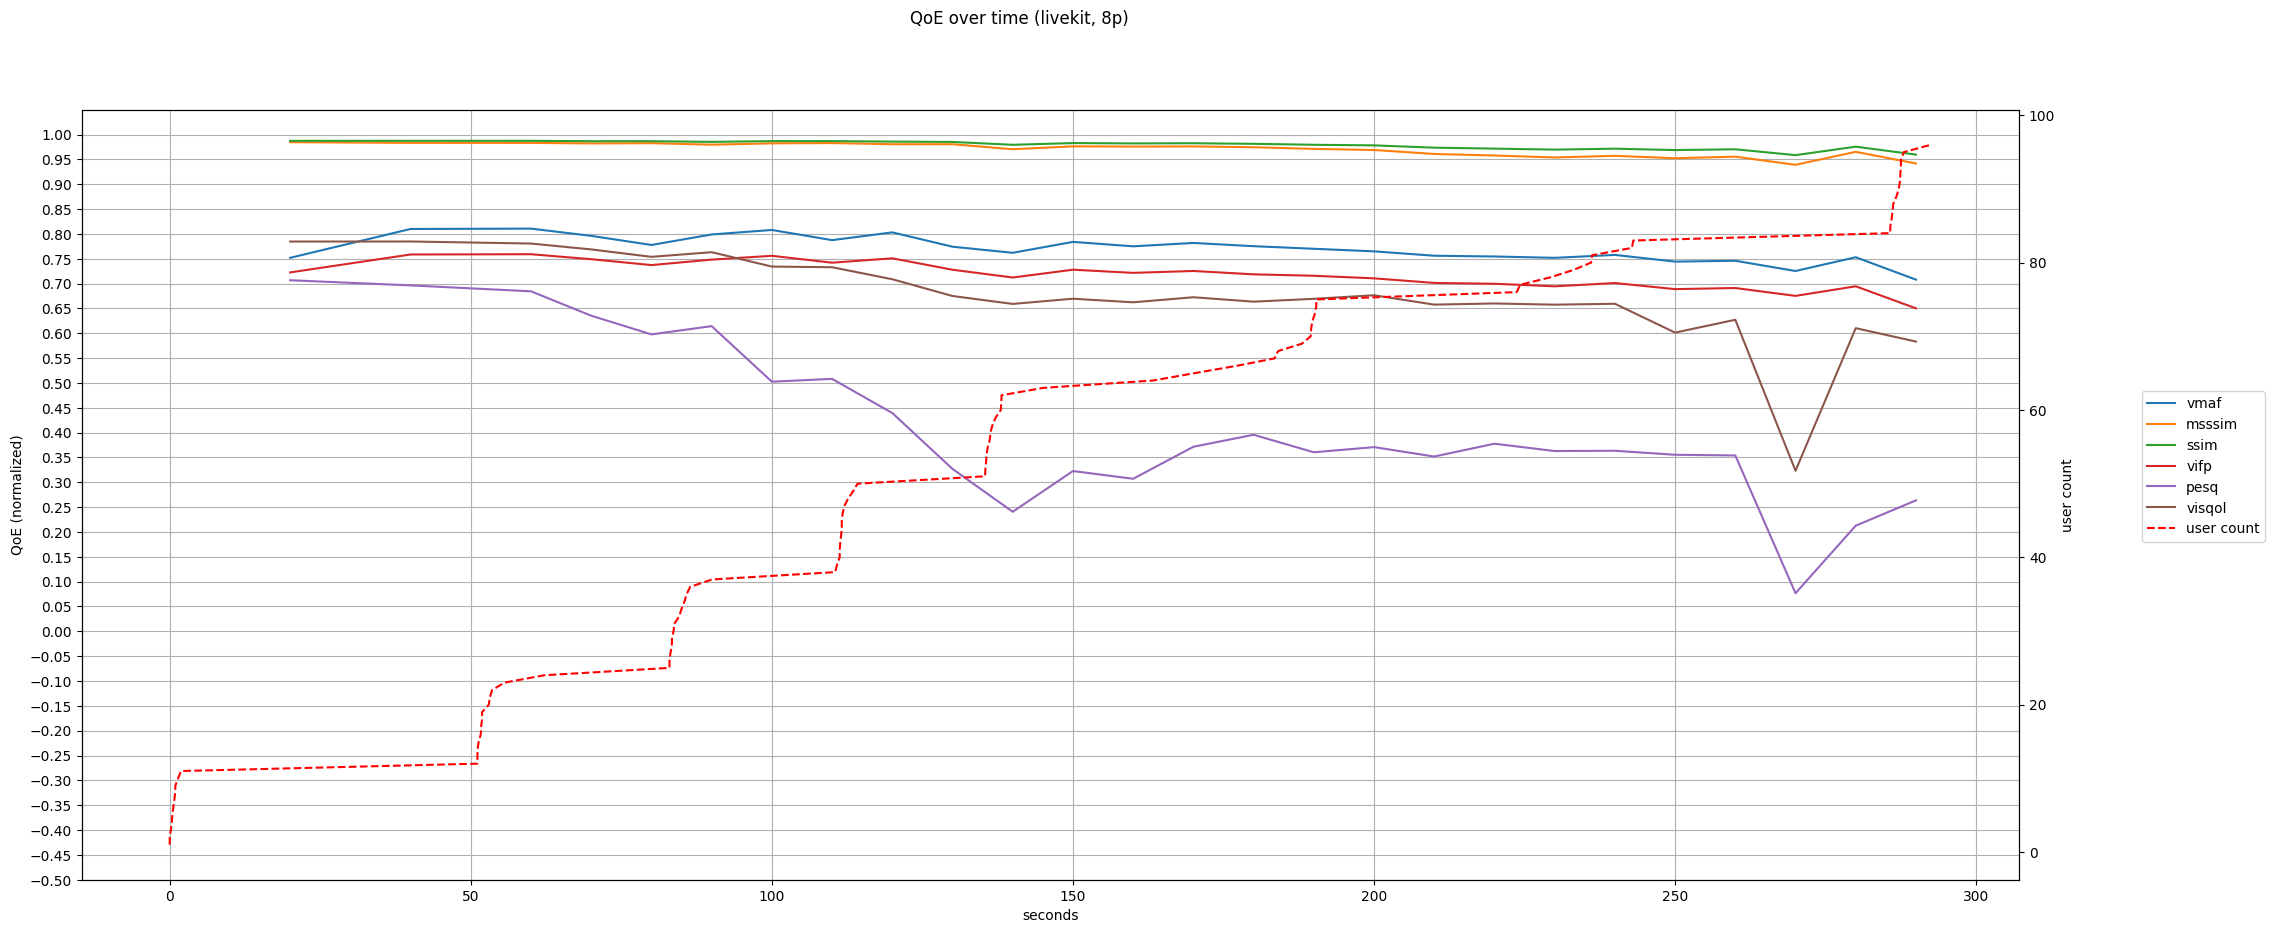

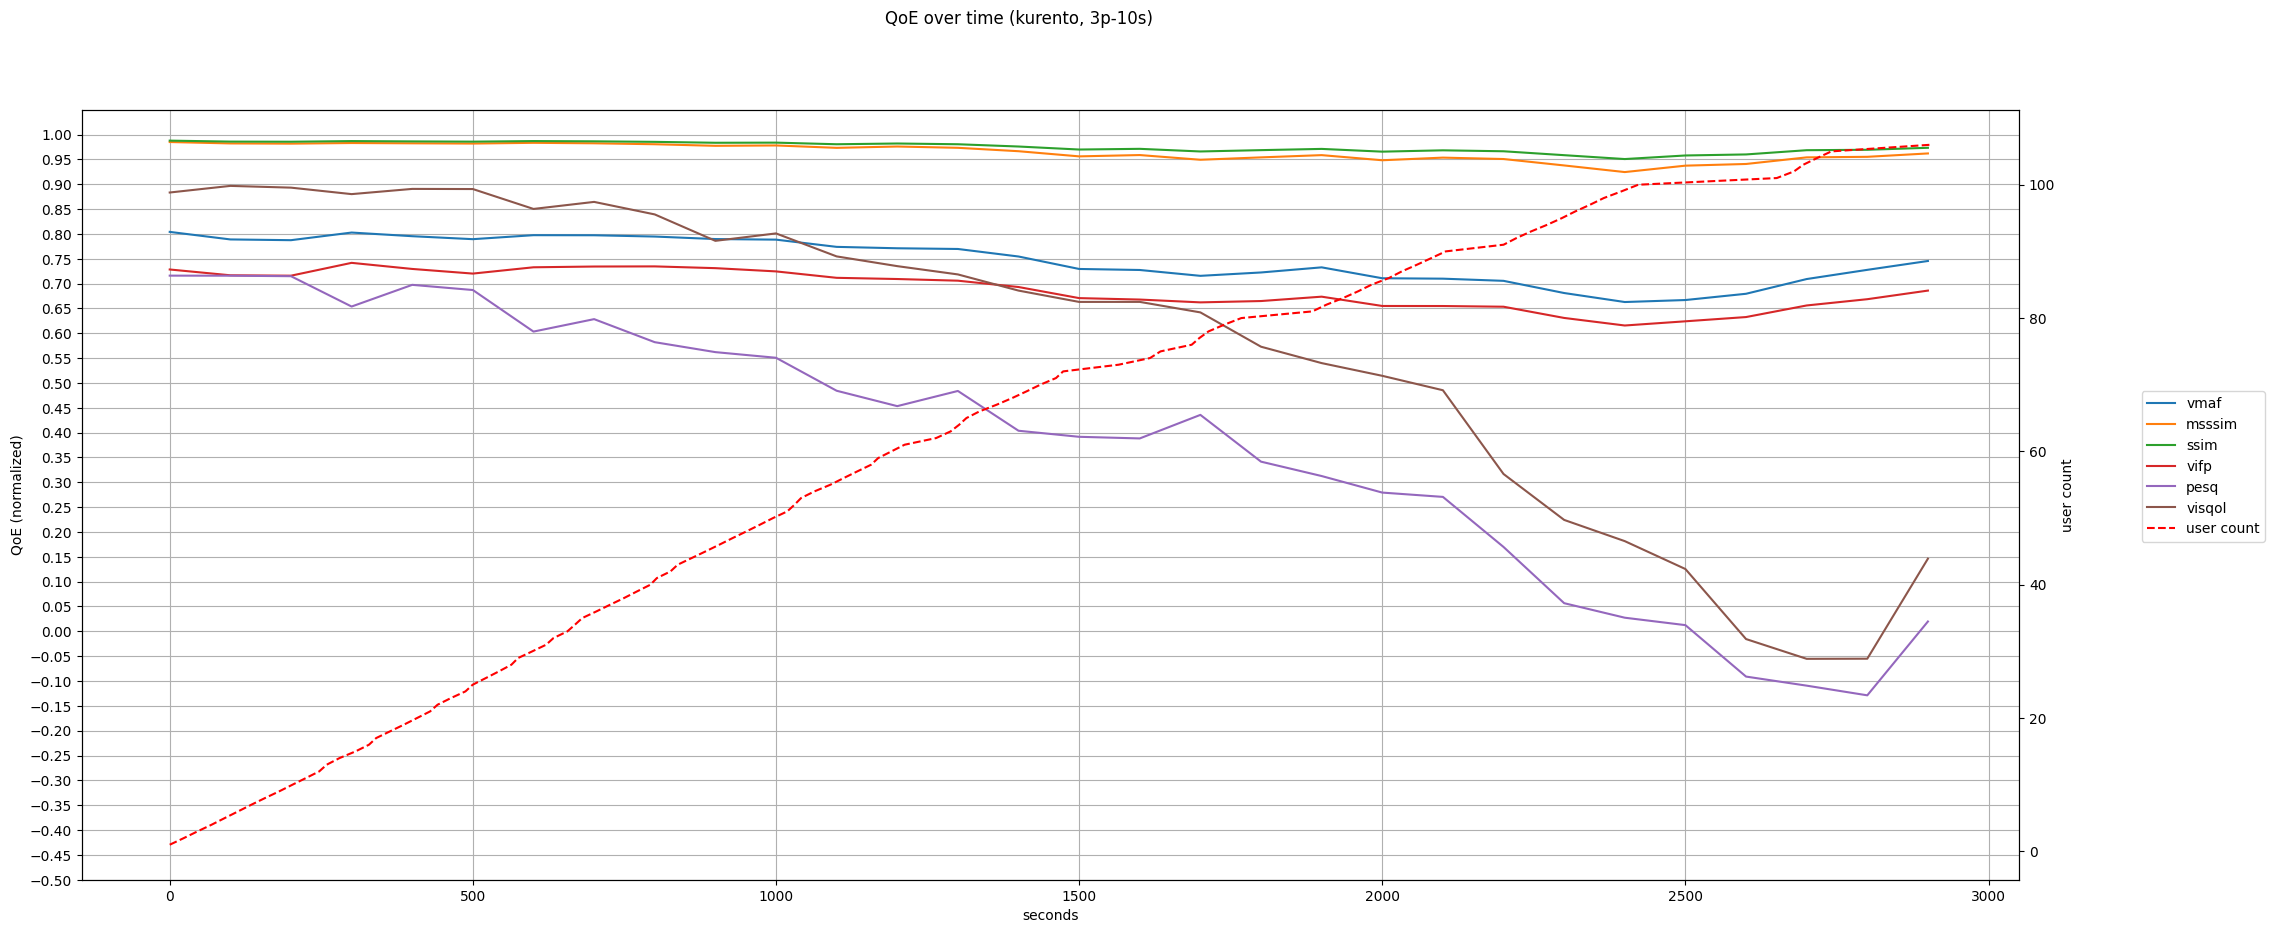

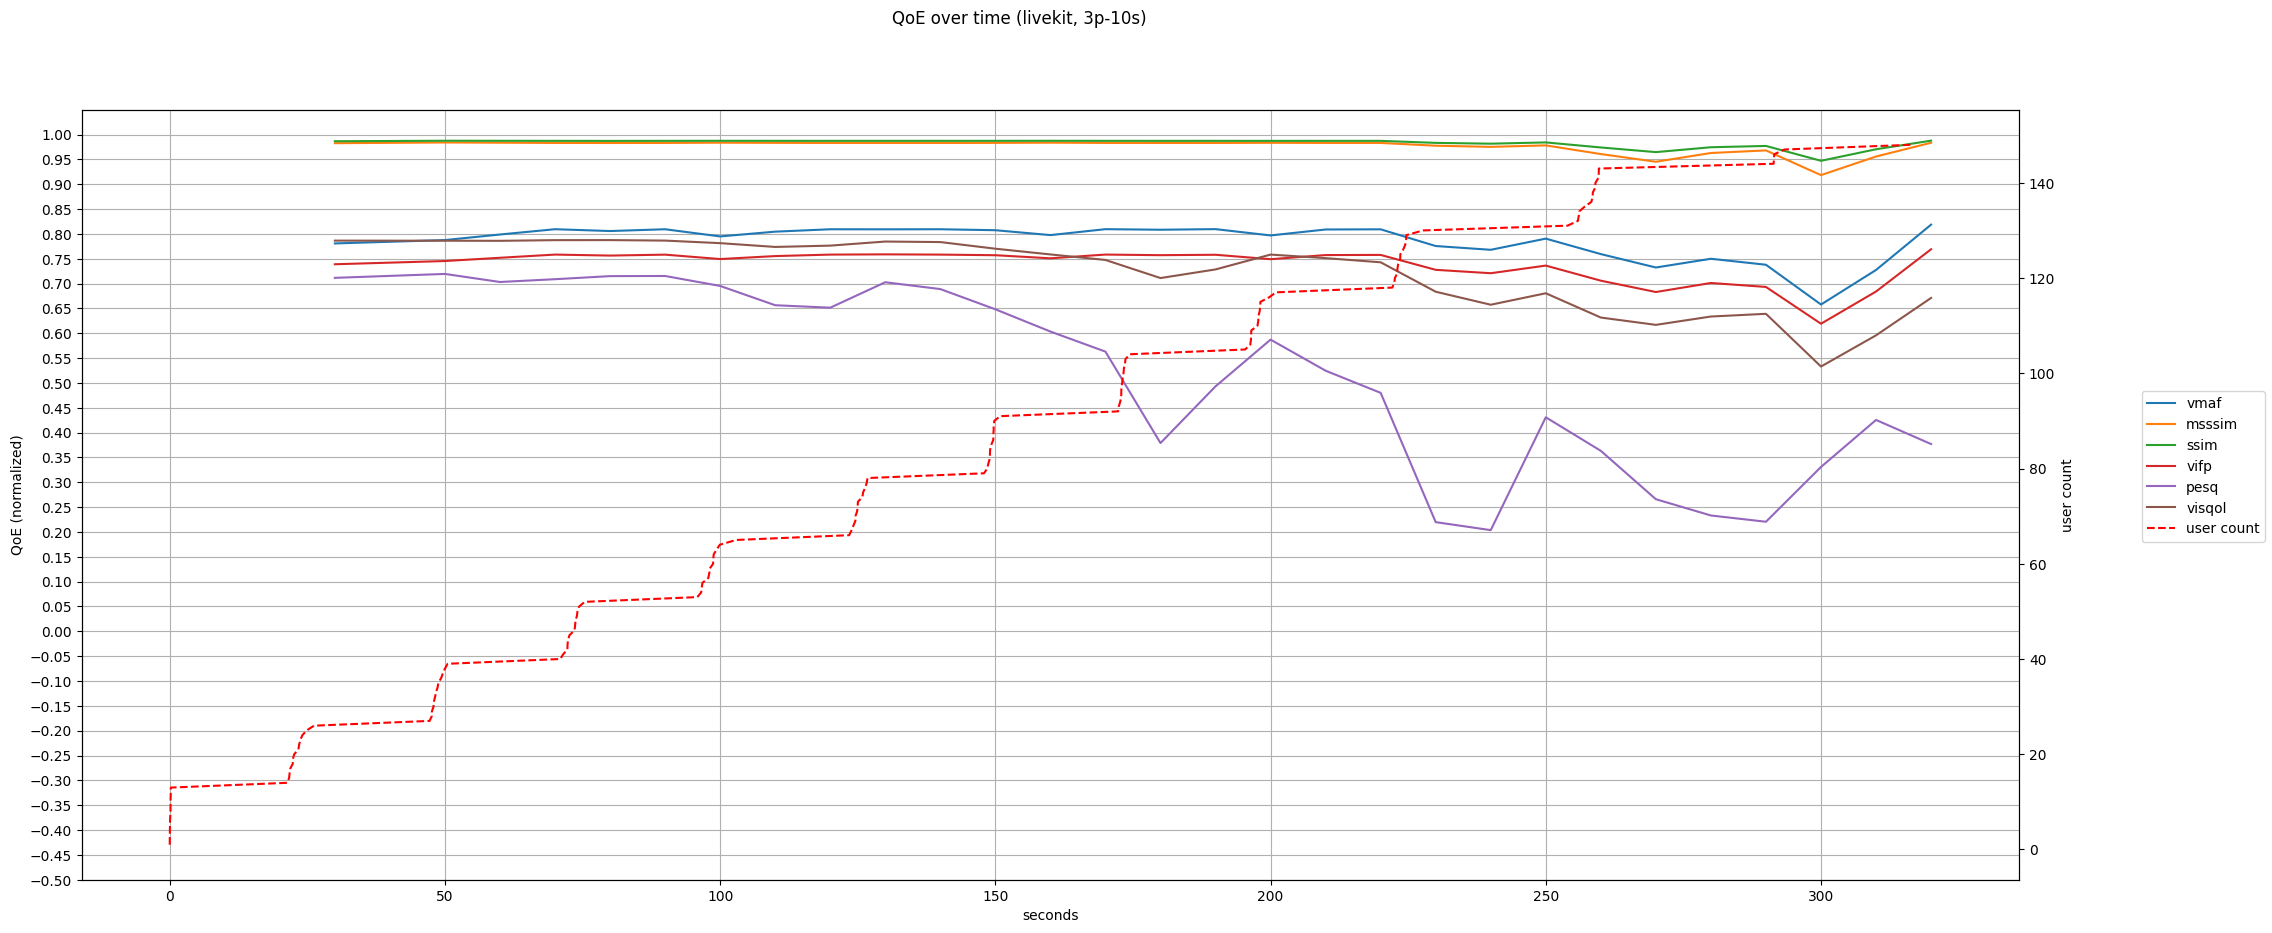

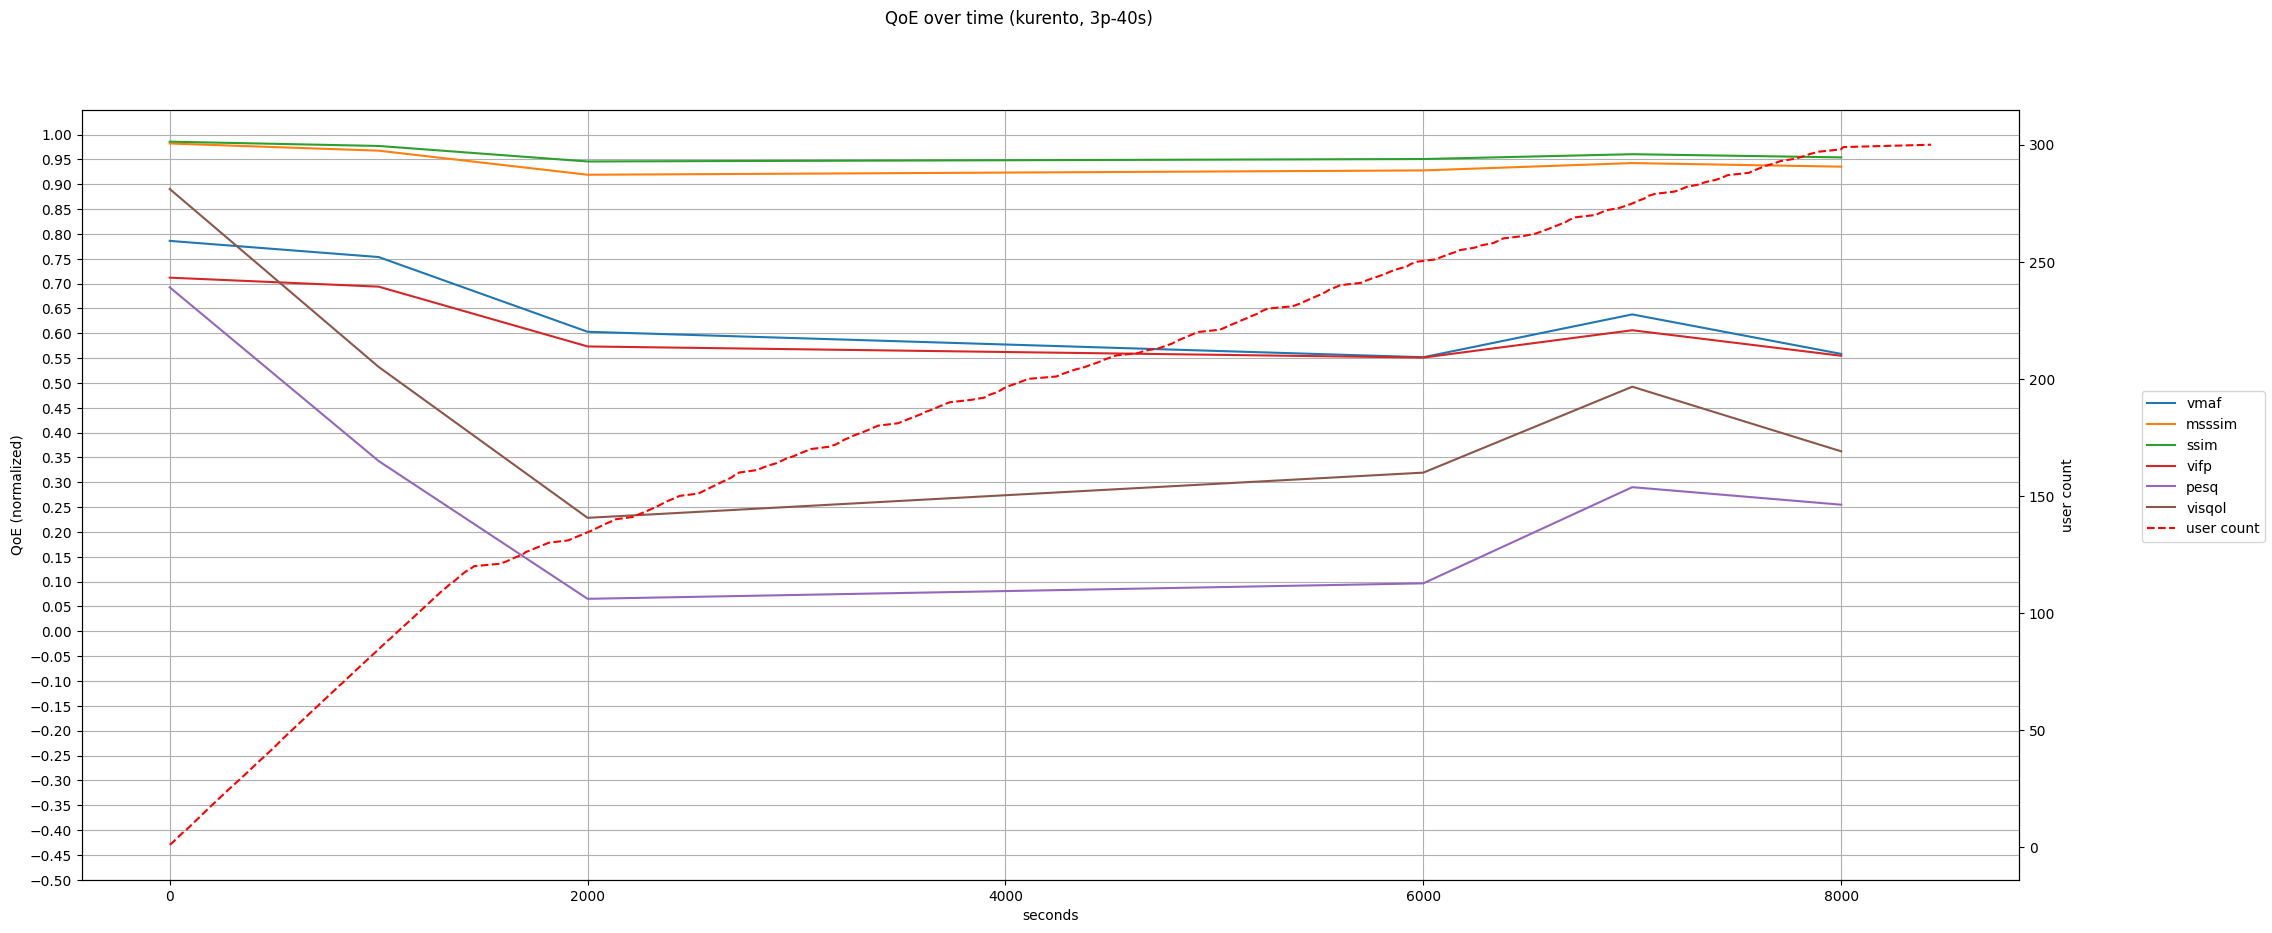

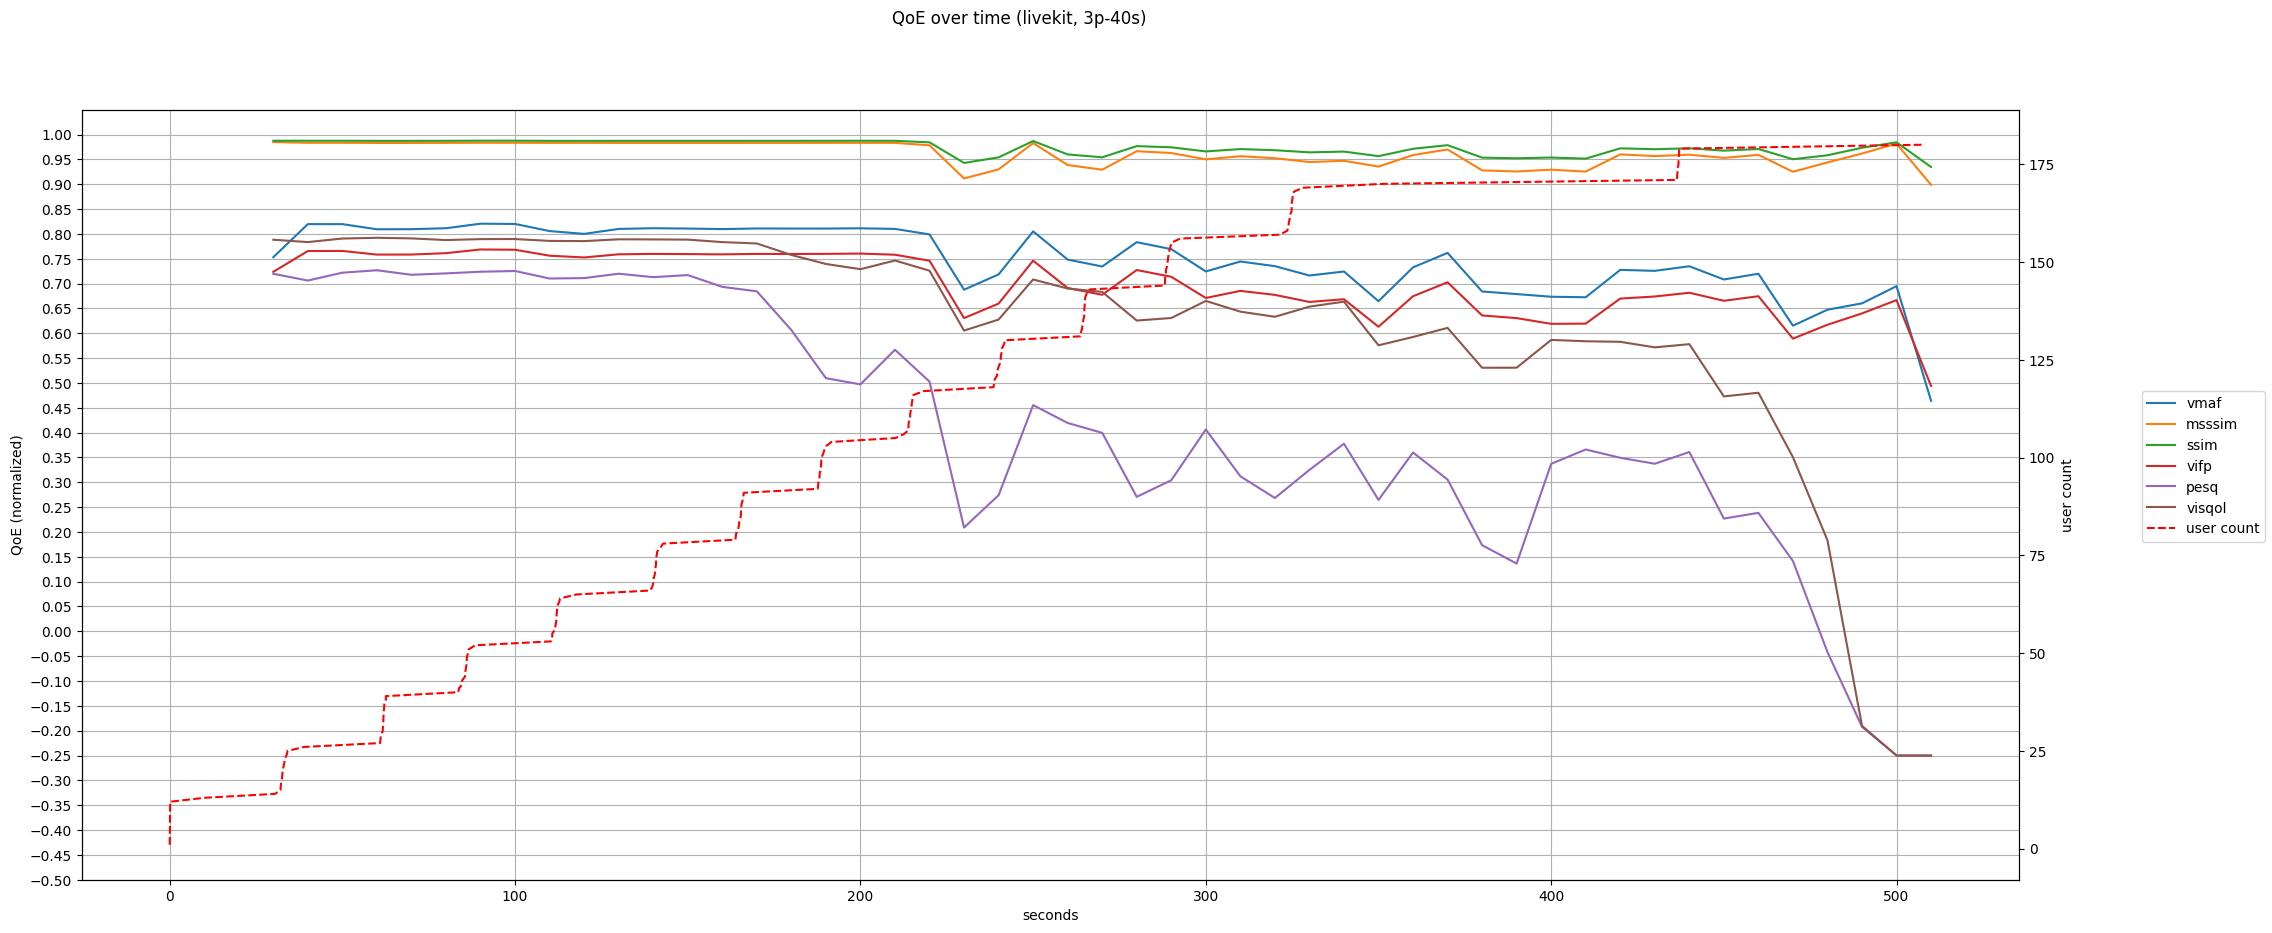

In [44]:
plt.rcParams["figure.figsize"] = [25, 10]
typologies = ["2p", "8p", "3p-10s", "3p-40s"]
media_nodes = ["kurento", "livekit"]
#metric="visqol"
colors = ["blue", "red"]
for typology in typologies:
    for media_node in media_nodes:
        fig, ax = plt.subplots()
        target_names = filter(
            lambda x: typology in x and media_node in x and "retry" in x, index_list_names
        )
        #max_x = -1
        for i, target_name in enumerate(target_names):
            df_tmp = df_list[index_list_names.index(target_name)].copy()
            #df_tmp = pd.read_csv(f"dfs_final/{target_name}.csv")
            user_join = pd.read_csv(f"dfs_final/{target_name}-user-join.csv")
            cpu_mem = pd.read_csv(f"dfs_final/{target_name}-medianode.csv")
            user_join = timestamp_to_secs(user_join, target_name)
            cpu_mem = timestamp_to_secs(cpu_mem, target_name)
            cpu_mem = cpu_mem.drop(columns=["@timestamp", "memory"]).dropna()
            # remove entries with cpu < 0.001
            # df_node = df_node[df_node["cpu"] > 0.001]
            #df_node = timestamp_to_secs(df_node, target_name)
            # aproximate cut_index to the nearest 10 seconds
            max_timestamp = df_tmp["cut_index"].max()
            if df_tmp["cut_index"].max() > 8000:
                df_tmp["cut_index"] = df_tmp["cut_index"].round(-3)
            elif df_tmp["cut_index"].max() > 1000:
                df_tmp["cut_index"] = df_tmp["cut_index"].round(-2)
            else:
                df_tmp["cut_index"] = df_tmp["cut_index"].round(-1)
            df_mean = df_tmp.groupby(["cut_index"]).mean(numeric_only=True)

            plot_name = target_name
            timestamp_user_values = user_join["timestamp_secs"].values
            # fill the timestamp_user_values with the last value to make the plot continuous

            timestamp_user_values = np.append(timestamp_user_values, max_timestamp)
            count = range(1, len(timestamp_user_values) + 1)
            if i == 0:
                ax2 = ax.twinx()
                ax2.plot(timestamp_user_values, count, color="red", label="user count", linestyle="--")
                ax2.set_ylabel("user count")
                ax3 = ax.twinx()


            if not df_mean.empty:
                for metric in qoe_metrics_normalized:
                    ax.plot(df_mean.index, df_mean[metric], label=metric)

        ax.set_xlabel("seconds")
        ax.set_ylabel("QoE (normalized)")
        ax.grid()
        ax.set_ylim(-0.5, 1.05)
        ax.set_yticks(np.arange(-0.5, 1.05, 0.05))

        fig.suptitle(f"QoE over time ({media_node}, {typology})")
        fig.legend(loc="right")
        fig.savefig(f"images_final/{typology}_{media_node}_qoe.png")